<h1>Chapter 10 - Creating Text Embedding Models</h1>
<i>Exploring methods for both training and fine-tuning embedding models.</i>

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961"><img src="https://img.shields.io/badge/Buy%20the%20Book!-grey?logo=amazon"></a>
<a href="https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/"><img src="https://img.shields.io/badge/O'Reilly-white.svg?logo=data:image/svg%2bxml;base64,PHN2ZyB3aWR0aD0iMzQiIGhlaWdodD0iMjciIHZpZXdCb3g9IjAgMCAzNCAyNyIgZmlsbD0ibm9uZSIgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIj4KPGNpcmNsZSBjeD0iMTMiIGN5PSIxNCIgcj0iMTEiIHN0cm9rZT0iI0Q0MDEwMSIgc3Ryb2tlLXdpZHRoPSI0Ii8+CjxjaXJjbGUgY3g9IjMwLjUiIGN5PSIzLjUiIHI9IjMuNSIgZmlsbD0iI0Q0MDEwMSIvPgo8L3N2Zz4K"></a>
<a href="https://github.com/HandsOnLLM/Hands-On-Large-Language-Models"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HandsOnLLM/Hands-On-Large-Language-Models/blob/main/chapter10/Chapter%2010%20-%20Creating%20Text%20Embedding%20Models.ipynb)

---

This notebook is for Chapter 10 of the [Hands-On Large Language Models](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961) book by [Jay Alammar](https://www.linkedin.com/in/jalammar) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/).

---

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961">
<img src="https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/images/book_cover.png" width="350"/></a>


### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---


In [ ]:
# %%capture
# !pip install -q accelerate>=0.27.2 peft>=0.9.0 bitsandbytes>=0.43.0 transformers>=4.38.2 trl>=0.7.11 sentencepiece>=0.1.99
# !pip install -q sentence-transformers>=3.0.0 mteb>=1.1.2 datasets>=2.18.0

文本嵌入模型是许多强大的自然语言处理应用程序的基础。它们为文本生成模型等已经令人印象深刻的技术奠定了基础。在本书中，我们已经在许多应用中使用了嵌入模型，比如监督分类、无监督分类、语义搜索，甚至给ChatGPT这样的文本生成模型提供了内存。

嵌入模型在该领域的重要性几乎不可能被夸大，因为它们是许多应用程序背后的驱动力量。因此，在本章中，我们将讨论各种方法，我们可以创建和微调嵌入模型，以增加其代表性和语义能力。

# Embeding Models

嵌入和嵌入模型已经在相当多的章节(第4章、第5章和第8章)中进行了讨论，从而展示了它们的实用性。在开始训练这样一个模型之前，让我们回顾一下我们从嵌入模型中学到的东西。

非结构化文本数据本身通常是相当难以处理的。它们不是我们可以直接处理、可视化并从中创建可操作结果的值。我们首先必须将这些文本数据转换成我们可以轻松处理的东西:数字表示。这个过程通常被称为将输入嵌入到输出可用向量，即嵌入。

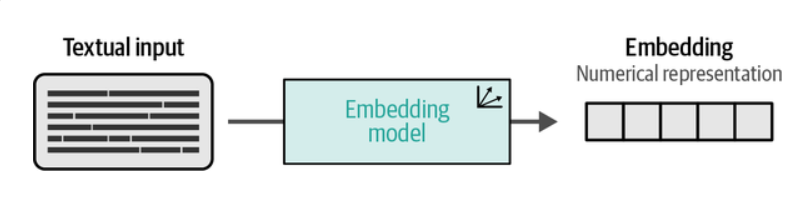

这种嵌入输入的过程通常由LLM执行，我们将其称为嵌入模型。这种模型的主要目的是尽可能准确地将文本数据表示为嵌入。

然而，在表示上做到准确是什么意思呢?通常，我们希望捕获文档的语义性质(即意义)。在实践中，这意味着我们期望彼此相似的文档向量是相似的，而每个讨论完全不同内容的文档的嵌入应该是不相似的。

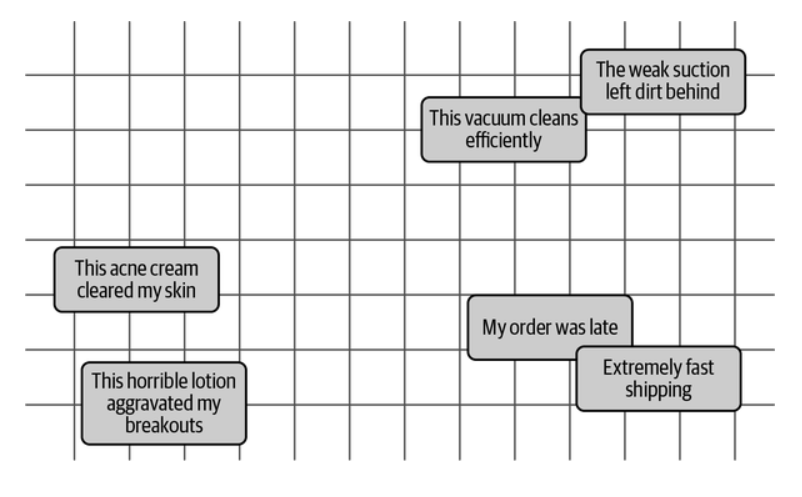

然而，一个嵌入模型可以出于多种目的进行训练。例如，当我们在构建情感分类器时，我们对文本的情感比对其语义相似度更感兴趣。如图所示，我们可以对模型进行微调，使文档在n维空间中基于它们的情感而不是它们的语义性质更接近。

无论哪种方式，嵌入模型的目的是学习是什么使某些文档彼此相似，我们可以指导这个过程。通过向模型提供足够的语义相似文档的示例，我们可以引导模型转向语义，而使用情感示例将引导模型朝着这个方向发展。

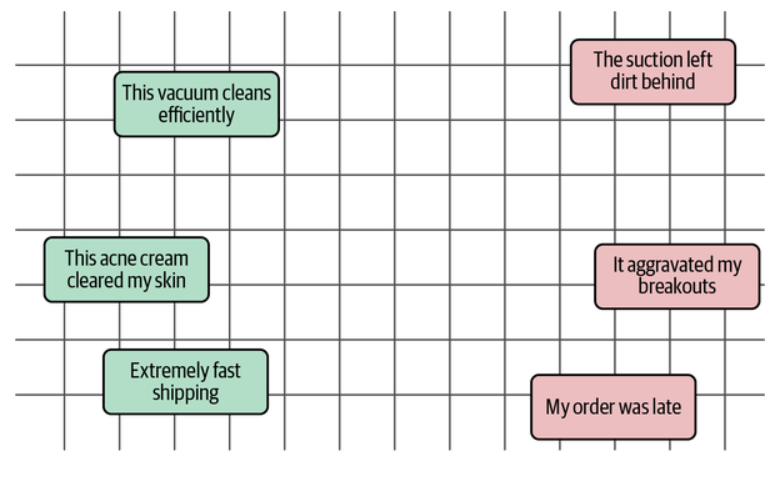

我们有很多方法可以训练、微调和引导嵌入模型，但其中最强大、应用最广泛的技术之一被称为对比学习。

# What is Contrastive Learning?

训练和微调文本嵌入模型的一个主要技术被称为对比学习。对比学习是一种旨在训练嵌入模型的技术，使相似的文档在向量空间中更接近，而不相似的文档则更远。它与第2章的word2vec方法非常相似。

对比学习的基本思想是，学习和建模文档之间相似/不相似的最佳方法是通过提供相似和不相似对的模型示例。为了准确地捕捉文档的语义性质，通常需要将其与另一个文档进行对比，以便模型学习不同或相似的原因。这种对比过程非常强大，并且与编写文档的上下文相关。

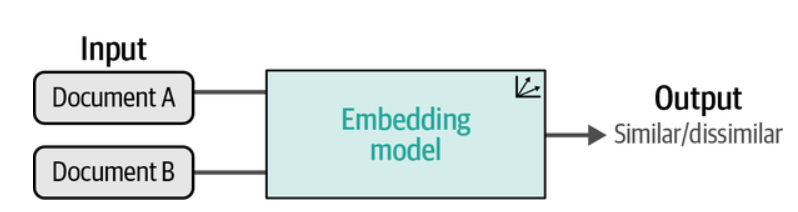

另一种理解对比学习的角度是从解释的本质入手。一个很好的例子是这样一则故事：一位记者问一个劫匪：“你为什么抢银行？”劫匪回答：“因为钱在那儿。” 尽管这个回答从事实角度看没错，但问题的本意并非是他为何专抢银行，而是他究竟为何抢劫。这就叫做对比性解释，指的是理解一个特定情况 “为什么是P？” ，并与其他可能性对比，即 “为什么是P而不是Q？” 。在这个例子中，这个问题可以有多种解释，最好的模型是提供一个替代方案:“你为什么抢劫银行(P)而不是守法(Q)?”

替代方案对于理解问题的重要性也适用于嵌入如何通过对比学习进行学习。通过展示一个相似和不相似对文档的模型，它开始学习是什么使某些东西相似/不相似，更重要的是，为什么。

例如，你可以通过让模型找到诸如“尾巴”、“鼻子”、“四条腿”等特征，来教模型理解狗是什么。这个学习过程可能相当困难，因为特征通常没有明确定义，并且可以用多种方式进行解释。有“尾巴”、“鼻子”和“四条腿”的生物也可以是猫。为了帮助模型转向我们感兴趣的方向，我们本质上问它，“为什么这是一只狗而不是一只猫?”通过提供两个概念之间的对比，它开始学习定义概念的特征，同时也学习不相关的特征。当我们把一个问题框定为一个对比时，我们会得到更多的信息。

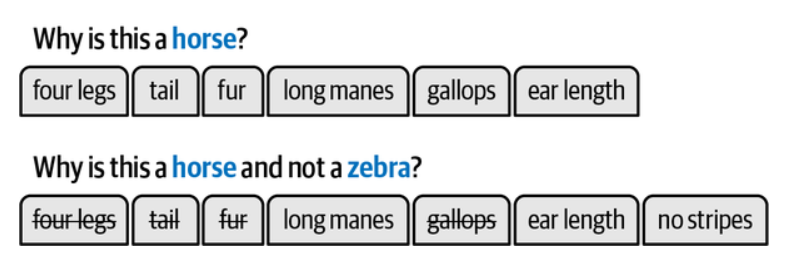

我们有很多方法可以应用对比学习来创建文本嵌入模型，但最著名的技术和框架是sentence-transformers

# SBERT

虽然对比学习的形式有很多种，但在自然语言处理社区中推广该技术的一个框架是 sentence-transformers。它的方法解决了原始BERT实现中创建句子嵌入的一个主要问题，即计算开销。之前 sentence-transformers，句子嵌入通常使用一种称为BERT交叉编码器的架构结构。

https://www.sbert.net/docs/cross_encoder/usage/usage.html

交叉编码器允许将两个句子同时传递到Transformer网络，以预测这两个句子的相似程度。它通过在原始架构中添加一个分类头来实现这一目标，该分类头可以输出相似度评分。然而，当你想在10000个句子的集合中找到最高的一对时，计算量会迅速上升。这将需要n·(n−1)/2 = 49,995,000次推理计算，因此会产生显著的开销。此外，交叉编码器通常不会生成嵌入，如图所示。相反，它输出输入句子之间的相似度评分。

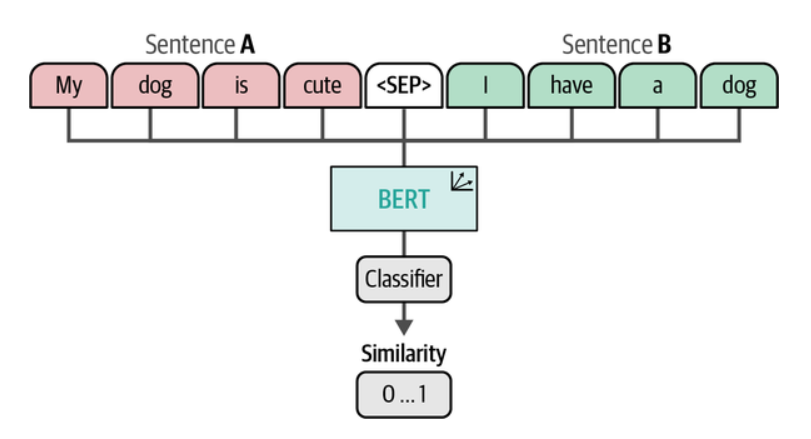

解决这种额外负担的一个办法是，通过对BERT模型的输出层求平均值，或使用[CLS]标记，来生成嵌入向量。然而，事实证明，这种方法还不如直接对词向量（如GloVe词向量）求平均值。

相反，sentence-transformers 的作者以不同的方式处理问题，并寻找一种快速的方法，并创建可以在语义上进行比较的嵌入。结果是一个优雅的替代原来的交叉编码器架构。不同于交叉编码器，在sentence-transformers中分类头被丢弃，而是在最终输出层上使用均值池化来生成嵌入。这个池化层平均单词嵌入，并返回一个固定维度的输出向量。这就保证了固定大小的嵌入。

sentence-transformers的训练采用连体架构。如图所示，在这种架构中，我们有两个相同的BERT模型，它们共享相同的权重和神经架构。将句子输入这些模型，通过对词元嵌入进行池化操作来生成句子的嵌入向量。然后，根据句子嵌入向量的相似度对模型进行优化。由于两个BERT模型的权重相同，我们可以使用单个模型，依次输入句子。

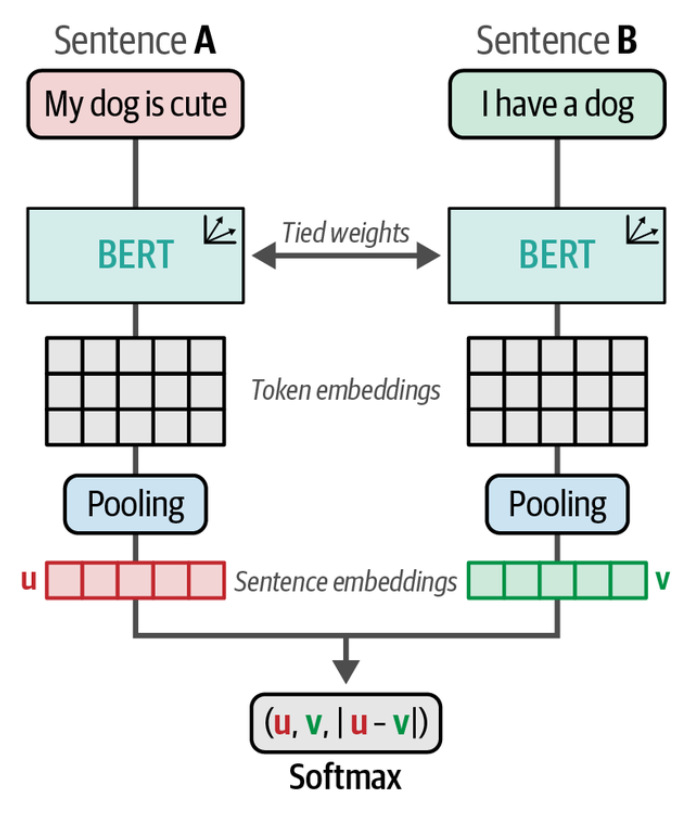

这些句子对的优化过程是通过损失函数完成的，损失函数会对模型的性能产生重大影响。在训练过程中，将每个句子的嵌入与嵌入之间的差异连接在一起。然后，通过softmax分类器对得到的嵌入进行优化。

最终得到的架构也被称为双编码器，或者就 sentence-BERT而言叫SBERT。虽然双编码器速度相当快，且能生成准确的句子表征，但交叉编码器通常比双编码器性能更优，不过它不会生成嵌入向量。

与交叉编码器一样，双编码器也利用了对比学习;通过优化句子对之间的(非)相似度，模型最终会学习到使句子成为现在的样子的东西。

要进行对比学习，我们需要两样东西。首先，我们需要构成相似/不相似对的数据。其次，我们需要定义模型如何定义和优化相似性。

# Creating an Embedding Model

有很多方法可以创建嵌入模型，但一般来说，我们更倾向于对比学习。这是许多嵌入模型的一个重要方面，因为这个过程允许它有效地学习语义表示。

## 生成对比样例

在预训练嵌入模型时，你常常会看到使用来自自然语言推理（NLI）数据集的数据。自然语言推理指的是这样一项任务：研究对于给定的前提，它是蕴含假设（蕴含关系）、与假设矛盾（矛盾关系），还是两者皆非（中立关系）。

例如，前提为“他在电影院看《寻梦环游记》”，假设为“他在家看《冰雪奇缘》”，那么这两个表述相互矛盾。相反，若前提是“他在电影院看《寻梦环游记》”，假设为“他在电影院看迪士尼电影《寻梦环游记》”，则这两个表述属于蕴含关系。

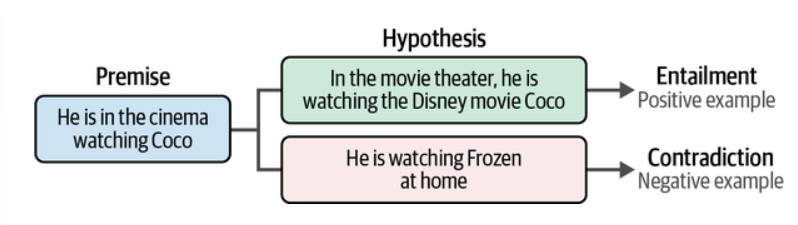

如果你仔细观察蕴涵和矛盾，它们描述的是两个输入彼此相似的程度。因此，我们可以使用NLI数据集生成反例(矛盾)和正例(蕴涵)来进行对比学习。

我们将在创建和微调嵌入模型的过程中使用的数据来自通用语言理解评估基准(GLUE)。这个GLUE基准由九个语言理解任务组成，用于评估和分析模型的性能。

其中一项任务涉及多类型自然语言推理（MNLI）语料库，该语料库包含392,702个句子对，并标注了蕴含关系（矛盾、中立、蕴含）。我们将使用其中50,000个已标注的句子对作为数据子集，构建一个小型示例，这样无需连续数小时进行训练。不过要注意，数据集越小，嵌入模型的训练或微调就越不稳定。如果可能，在保证数据质量的前提下，更宜选用更大的数据集。

## **Data**

In [ ]:
from datasets import load_dataset

# Load MNLI dataset from GLUE
# 0 = entailment, 1 = neutral, 2 = contradiction
train_dataset = load_dataset("glue", "mnli", split="train").select(range(50_000))
train_dataset = train_dataset.remove_columns("idx")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_dataset[2]

{'premise': 'One of our number will carry out your instructions minutely.',
 'hypothesis': 'A member of my team will execute your orders with immense precision.',
 'label': 0}

## **Model**

现在我们有了带有训练样例的数据集，我们将需要创建我们的嵌入模型。我们通常选择一个现有的 sentence-transformers 模型并对模型进行微调，但在这个例子中，我们将从头开始训练一个嵌入。

这意味着我们必须定义两件事。首先，一个预训练的Transformer模型，作为嵌入单个单词的功能。我们将使用BERT基础模型，因为它是一个很好的引入模型。然而，许多其他存在的模型也有 被评估使用sentence-transformers。

In [ ]:
from sentence_transformers import SentenceTransformer

# Use a base model
embedding_model = SentenceTransformer('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


接下来，我们需要定义一个损失函数，以便对模型进行优化。如本节开头所述，sentence-transformers最初使用的方法之一就是softmax损失函数。为便于说明，我们暂且使用该函数，不过稍后我们会探讨性能更优的损失函数。

## **Loss Function**

In [ ]:
from sentence_transformers import losses

# Define the loss function. In soft-max loss, we will also need to explicitly set the number of labels.
train_loss = losses.SoftmaxLoss(
    model=embedding_model,
    sentence_embedding_dimension=embedding_model.get_sentence_embedding_dimension(),
    num_labels=3
)

在我们训练模型之前，我们定义了一个评估器来评估模型在训练过程中的表现，这也决定了要保存的最佳模型。

我们可以使用语义文本相似基准(Semantic text Similarity Benchmark, STSB)对模型的性能进行评估。它是人工标记的句子对的集合，相似度得分在1到5之间。

我们使用这个数据集来探究模型在语义相似度任务中的表现如何。此外，我们会对语义文本相似度基准（STSB）数据进行处理，确保所有值都在0到1之间。

## Evaluation

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Create an embedding similarity evaluator for stsb
val_sts = load_dataset('glue', 'stsb', split='validation')
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score/5 for score in val_sts["label"]],
    main_similarity="cosine",
)

## **Training**

In [ ]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

# Define the training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="base_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
)

值得注意的是以下参数：
- num_train_epochs:训练回合数。为了更快的训练，我们将这个值保持在1，但通常建议增加这个值。
- per_device_train_batch_size:在训练期间，在每个设备(例如，GPU或CPU)上同时处理的样本数量。数值越高通常意味着训练速度越快。
- per_device_eval_batch_size:在评估期间，在每个设备(例如，GPU或CPU)上同时处理的样本数量。数值越高通常意味着评估越快。
- warmup_steps:学习率将从零线性增加到为训练过程定义的初始学习率的步数。注意，我们没有为这个训练过程指定一个自定义学习率。
- fp16:通过启用此参数，我们允许混合精度训练，其中使用16位浮点数(FP16)而不是默认的32位(FP32)执行计算。这减少了内存使用，并潜在地提高了训练速度。

现在我们已经定义了我们的数据、嵌入模型、损失和评估器，我们可以开始训练我们的模型了。

In [ ]:
from sentence_transformers.trainer import SentenceTransformerTrainer

# Train embedding model
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator
)
trainer.train()

Step,Training Loss
100,1.080700
200,0.959400
300,0.916200
400,0.870200
500,0.849100
600,0.854200
700,0.835200
800,0.825200
900,0.818100
1000,0.800300


Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

TrainOutput(global_step=1563, training_loss=0.8453957184872716, metrics={'train_runtime': 372.5713, 'train_samples_per_second': 134.202, 'train_steps_per_second': 4.195, 'total_flos': 0.0, 'train_loss': 0.8453957184872716, 'epoch': 1.0})

In [ ]:
# Evaluate our trained model
evaluator(embedding_model)

{'pearson_cosine': 0.3710938716460552,
 'spearman_cosine': 0.45148122260403883,
 'pearson_manhattan': 0.4037396904694362,
 'spearman_manhattan': 0.4396893995197567,
 'pearson_euclidean': 0.390788259199341,
 'spearman_euclidean': 0.43444104358464286,
 'pearson_dot': 0.3392927926047231,
 'spearman_dot': 0.3530708415227247,
 'pearson_max': 0.4037396904694362,
 'spearman_max': 0.45148122260403883}

我们有几种不同的距离测量方法。我们最感兴趣的是 “pearson_cosine”，这是中心向量之间的余弦相似度。它是一个介于0和1之间的值，值越大表示相似度越高。

## 深入评估

一个好的嵌入模型不仅仅是在STSB基准上取得好成绩!正如我们前面所观察到的，GLUE基准测试有许多任务，我们可以评估我们的嵌入模型。然而，还有更多的基准测试允许对嵌入模型进行评估。为了统一这种评估程序，开发了大规模文本嵌入基准测试(MTEB)。MTEB涵盖8个嵌入任务，涵盖58个数据集和112种语言。

# MTEB

In [ ]:
from mteb import MTEB

# Choose evaluation task
evaluation = MTEB(tasks=["Banking77Classification"])

# Calculate results
results = evaluation.run(embedding_model)
results

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


{'Banking77Classification': {'mteb_version': '1.1.2',
  'dataset_revision': '0fd18e25b25c072e09e0d92ab615fda904d66300',
  'mteb_dataset_name': 'Banking77Classification',
  'test': {'accuracy': 0.46022727272727276,
   'f1': 0.45802738001849663,
   'accuracy_stderr': 0.009556987908238961,
   'f1_stderr': 0.01072225943077292,
   'main_score': 0.46022727272727276,
   'evaluation_time': 29.63}}}

这个评估基准的伟大之处不仅在于任务和语言的多样性，而且甚至节省了评估时间。虽然存在许多嵌入模型，但我们通常希望那些既准确又具有低延迟的模型。使用嵌入模型的任务，如语义搜索，通常受益于并且需要快速推理。

⚠️ **VRAM Clean-up** - You will need to run the code below to partially empty the VRAM (GPU RAM). If that does not work, it is advised to restart the notebook instead. You can check the resources on the right-hand side (if you are using Google Colab) to check whether the used VRAM is indeed low. You can also run `!nivia-smi` to check current usage.

In [ ]:
# # Empty and delete trainer/model
# trainer.accelerator.clear()
# del trainer, embedding_model

# # Garbage collection and empty cache
# import gc
# import torch

# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# Loss Fuctions

⚠️ **VRAM Clean-up**
* `Restart` the notebook in order to clean-up memory if you move on to the next training example.

我们使用softmax loss来训练我们的模型，以说明第一个 sentence-transformers 模型是如何训练的。然而，不仅有各种各样的损失函数可供选择，而且通常不建议使用softmax损失，因为有性能更优的损失函数。

我们不需要遍历每一个损失函数，这里有两个通常使用的损失函数，它们似乎表现得很好，即:
- 余弦相似度
- 多重负排序(MNR)损失

## Cosine Similarity Loss

余弦相似度损失是一种直观且易用的损失函数，适用于多种不同的用例和数据集。它通常用于语义文本相似度任务。在这些任务中，会为文本对分配一个相似度分数，我们基于此对模型进行优化。

我们没有严格的正面或负面的句子对，而是假设在一定程度上相似或不相似的句子对。通常，这个值介于0和1之间，分别表示不相似和相似。

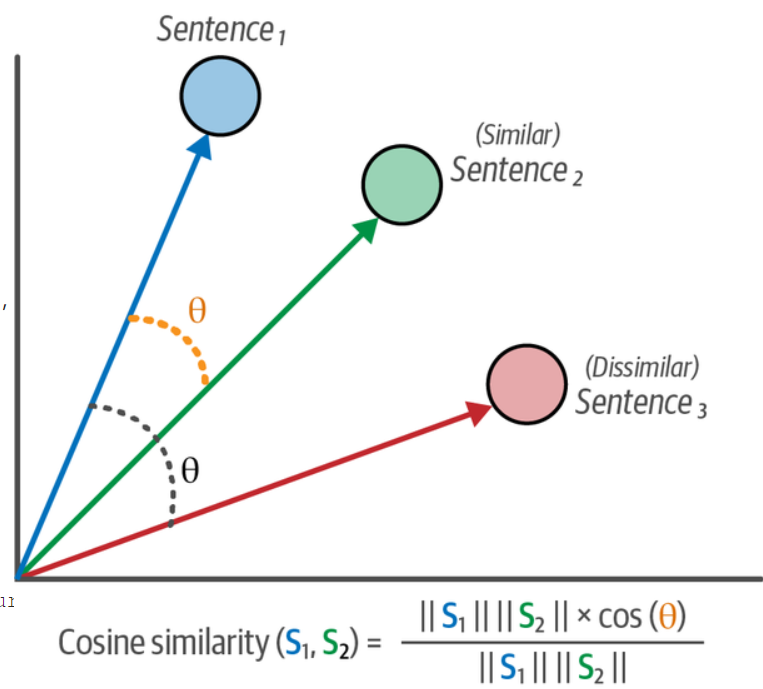

余弦相似度损失很简单——它计算两个文本的两个嵌入之间的余弦相似度，并将其与标记的相似度评分进行比较。模型将学习识别句子之间的相似度。

余弦相似度损失直观地使用数据效果最好，其中你有一对句子和标签，表明它们的相似度在0到1之间。为了在我们的NLI数据集上使用这种损失，我们需要将蕴涵(0)、中性(1)和矛盾(2)标签转换为0到1之间的值。蕴涵表示句子之间的相似度很高，因此我们给它的相似度评分为1。相比之下，由于中性和矛盾都表示不相似，我们给这些标签的相似度评分为0:

In [ ]:
from datasets import Dataset, load_dataset

# Load MNLI dataset from GLUE
# 0 = entailment, 1 = neutral, 2 = contradiction
train_dataset = load_dataset("glue", "mnli", split="train").select(range(50_000))
train_dataset = train_dataset.remove_columns("idx")

# (neutral/contradiction)=0 and (entailment)=1
mapping = {2: 0, 1: 0, 0:1}
train_dataset = Dataset.from_dict({
    "sentence1": train_dataset["premise"],
    "sentence2": train_dataset["hypothesis"],
    "label": [float(mapping[label]) for label in train_dataset["label"]]
})

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Create an embedding similarity evaluator for stsb
val_sts = load_dataset('glue', 'stsb', split='validation')
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score/5 for score in val_sts["label"]],
    main_similarity="cosine"
)

In [ ]:
from sentence_transformers import losses, SentenceTransformer
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

# Define model
embedding_model = SentenceTransformer('bert-base-uncased')

# Loss function
train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Define the training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="cosineloss_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
)

# Train model
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Step,Training Loss
100,0.231900
200,0.168900
300,0.170900
400,0.157800
500,0.152900
600,0.156100
700,0.149300
800,0.154500
900,0.150900
1000,0.145600


Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

TrainOutput(global_step=1563, training_loss=0.15676780793427353, metrics={'train_runtime': 364.4779, 'train_samples_per_second': 137.183, 'train_steps_per_second': 4.288, 'total_flos': 0.0, 'train_loss': 0.15676780793427353, 'epoch': 1.0})

In [ ]:
# Evaluate our trained model
evaluator(embedding_model)

{'pearson_cosine': 0.7222320710908391,
 'spearman_cosine': 0.725059765496038,
 'pearson_manhattan': 0.7338172618636865,
 'spearman_manhattan': 0.7323465534428775,
 'pearson_euclidean': 0.7332726423686017,
 'spearman_euclidean': 0.7316943270141215,
 'pearson_dot': 0.6603672299249149,
 'spearman_dot': 0.6624301208511642,
 'pearson_max': 0.7338172618636865,
 'spearman_max': 0.7323465534428775}

⚠️ **VRAM Clean-up**
* `Restart` the notebook in order to clean-up memory if you move on to the next training example.

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

## Multiple Negatives Ranking Loss

多负例排序（MNR）损失，常被称作InfoNCE或NTXentLoss ，该损失函数使用正向句子对，或包含一对正向句子与一个额外无关句子的三元组。这个无关句子被称为负例，体现了正向句子之间的差异。

例如，可能存在问题/答案对、图像/图像说明对、论文标题/论文摘要对等。这些对子的优点在于，我们可以确定它们是强正例对。在多负例排序损失中，负例对是通过将一个正例对与另一个正例对混合构建而成。以论文标题和摘要为例，将一篇论文的标题与一篇完全不同论文的摘要组合，就会生成一个负例对。这些负例被称为批内负例，也可用于生成三元组。

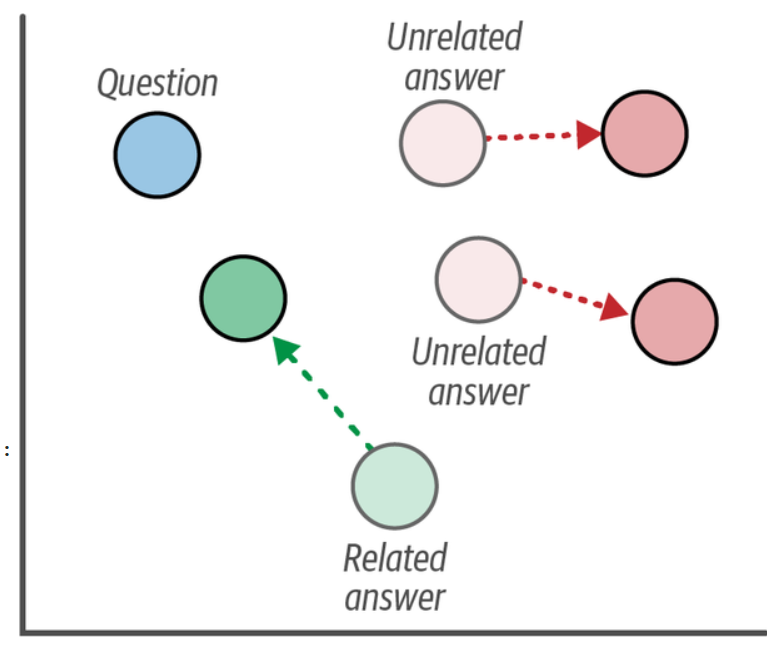

在生成这些正对和负对之后，我们计算它们的嵌入并应用余弦相似度。然后用这些相似度分数来回答这个问题，这些对是负的还是正的?换句话说，它被视为一个分类任务，我们可以使用交叉熵损失来优化模型。

为了制作这些三元组，我们从一个锚句子开始(即标记为“前提”)，它用于比较其他句子。然后，使用MNLI数据集，我们只选择正面的句子对(即标记为“蕴涵”)。为了添加否定句，我们随机抽取句子作为“假设”。

In [ ]:
import random
from tqdm import tqdm
from datasets import Dataset, load_dataset

# # Load MNLI dataset from GLUE
mnli = load_dataset("glue", "mnli", split="train").select(range(50_000))
mnli = mnli.remove_columns("idx")
mnli = mnli.filter(lambda x: True if x['label'] == 0 else False)

# Prepare data and add a soft negative
train_dataset = {"anchor": [], "positive": [], "negative": []}
soft_negatives = mnli["hypothesis"]
random.shuffle(soft_negatives)
for row, soft_negative in tqdm(zip(mnli, soft_negatives)):
    train_dataset["anchor"].append(row["premise"])
    train_dataset["positive"].append(row["hypothesis"])
    train_dataset["negative"].append(soft_negative)
train_dataset = Dataset.from_dict(train_dataset)
len(train_dataset)

16875it [00:01, 14110.96it/s]


16875

由于我们只选择标有“蕴涵”的句子，因此行数从50,000行减少到16,875行。

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Create an embedding similarity evaluator for stsb
val_sts = load_dataset('glue', 'stsb', split='validation')
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score/5 for score in val_sts["label"]],
    main_similarity="cosine"
)

In [ ]:
from sentence_transformers import losses, SentenceTransformer
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

# Define model
embedding_model = SentenceTransformer('bert-base-uncased')

# Loss function
train_loss = losses.MultipleNegativesRankingLoss(model=embedding_model)

# Define the training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="mnrloss_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
)

# Train model
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Step,Training Loss
100,0.345200
200,0.105500
300,0.079000
400,0.062200
500,0.069000


Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

TrainOutput(global_step=528, training_loss=0.12795479415041028, metrics={'train_runtime': 180.866, 'train_samples_per_second': 93.301, 'train_steps_per_second': 2.919, 'total_flos': 0.0, 'train_loss': 0.12795479415041028, 'epoch': 1.0})

In [ ]:
# Evaluate our trained model
evaluator(embedding_model)

{'pearson_cosine': 0.8070727434643791,
 'spearman_cosine': 0.8106193672462586,
 'pearson_manhattan': 0.8213132116968124,
 'spearman_manhattan': 0.8164551132664518,
 'pearson_euclidean': 0.820988086354926,
 'spearman_euclidean': 0.8160139830687847,
 'pearson_dot': 0.7429357515240518,
 'spearman_dot': 0.7316164586329814,
 'pearson_max': 0.8213132116968124,
 'spearman_max': 0.8164551132664518}

与我们之前训练的损失(0.72)的模型相比，我们的MNR损失(0.80)的模型似乎更准确。

我们使用这个损失函数的方式有一个缺点。由于否定是从其他问题/答案对中采样的，因此我们使用的这些批处理或“简单”否定可能与问题完全无关。因此，嵌入模型找到问题的正确答案的任务变得相当容易。相反，我们希望有与问题非常相关但不是正确答案的否定。这些否定被称为困难否定。由于这将使嵌入模型的任务变得更加困难，因为它必须学习更细致入微的表示，因此嵌入模型的性能通常会提高很多。

关于困难否定的一个很好例子如下。假设我们有这样一个问题：“阿姆斯特丹有多少人口？” 与之相关的一个答案会是：“阿姆斯特丹居住着近一百万人。” 为了生成一个合适的困难否定，我们理想的情况是让答案包含一些关于阿姆斯特丹以及该市人口数量的内容。例如：“乌得勒支居住着超过一百万人，比阿姆斯特丹人口多。” 这个答案与问题相关，但并非实际答案，所以这会是一个很好的困难否定。

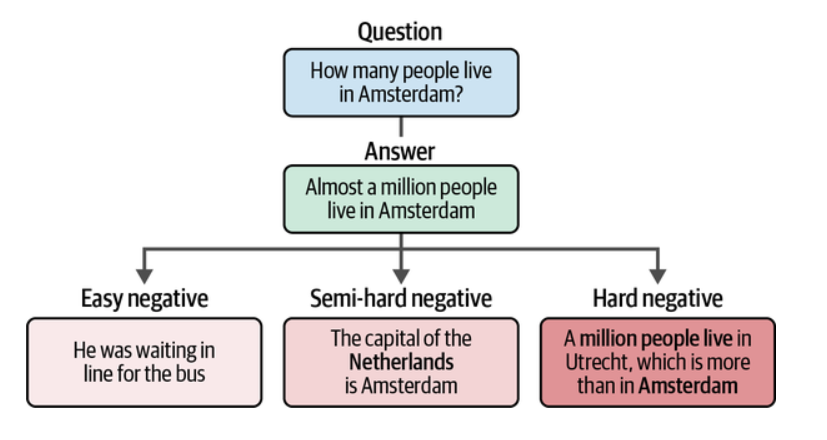

收集负例大致可以分为以下三个步骤：
- 简单否定：通过我们之前做的随机抽样文件。
- 半难否定：使用预训练的嵌入模型，我们可以在所有句子嵌入上应用余弦相似度来找到那些高度相关的句子。一般来说，这不会导致困难否定，因为这种方法只会找到相似的句子，而不是问题/答案对。
- 困难否定：这些通常需要手动标记(例如，通过生成半难否定)，或者您可以使用生成模型来判断或生成句子对。

# **Fine-tuning**

⚠️ **VRAM Clean-up**
* `Restart` the notebook in order to clean-up memory if you move on to the next training example.

在上一节中，我们从头开始学习了训练嵌入模型的基础知识，并了解了如何利用损失函数进一步优化其性能。这种方法虽然相当强大，但需要从头开始创建一个嵌入模型。这个过程可能会相当昂贵和耗时。

相反, sentence-transformers 框架允许几乎所有的嵌入模型被用作微调的基础。我们可以选择一个已经在大量数据上训练过的嵌入模型，并根据我们的特定数据或目的对其进行微调。

根据数据的可用性和领域，有几种方法可以对模型进行微调。我们将介绍两种这样的方法，并展示利用预训练的嵌入模型的强度。

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

## **Supervised**

微调嵌入模型最直接的方法，是重复我们之前训练模型的过程，但将 “bert - base - uncased” 替换为预训练的句子转换器模型。可供选择的模型有很多，一般来说，all - MiniLM - L6 - v2 在众多应用场景中表现出色，而且由于其模型规模小，运行速度相当快。

我们使用与在MNR损失示例中训练模型相同的数据，但使用预训练的嵌入模型进行微调。

In [ ]:
from datasets import load_dataset
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Load MNLI dataset from GLUE
# 0 = entailment, 1 = neutral, 2 = contradiction
train_dataset = load_dataset("glue", "mnli", split="train").select(range(50_000))
train_dataset = train_dataset.remove_columns("idx")

# Create an embedding similarity evaluator for stsb
val_sts = load_dataset('glue', 'stsb', split='validation')
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score/5 for score in val_sts["label"]],
    main_similarity="cosine"
)

训练步骤类似于我们之前的例子，但没有使用 “bert-base-uncased”, 我们可以使用预训练的嵌入模型来代替。

In [ ]:
from sentence_transformers import losses, SentenceTransformer
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

# Define model
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Loss function
train_loss = losses.MultipleNegativesRankingLoss(model=embedding_model)

# Define the training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="finetuned_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
)

# Train model
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator
)
trainer.train()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Step,Training Loss
100,0.155500
200,0.110000
300,0.118600
400,0.115300
500,0.110700
600,0.101000
700,0.113100
800,0.099800
900,0.109600
1000,0.105800


Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

TrainOutput(global_step=1563, training_loss=0.10982195932897176, metrics={'train_runtime': 117.3739, 'train_samples_per_second': 425.989, 'train_steps_per_second': 13.316, 'total_flos': 0.0, 'train_loss': 0.10982195932897176, 'epoch': 1.0})

In [ ]:
# Evaluate our trained model
evaluator(embedding_model)

{'pearson_cosine': 0.8489503881223601,
 'spearman_cosine': 0.8484667083117318,
 'pearson_manhattan': 0.8503843871673679,
 'spearman_manhattan': 0.8475679105384369,
 'pearson_euclidean': 0.8513072191805562,
 'spearman_euclidean': 0.8484667083117318,
 'pearson_dot': 0.8489503890256918,
 'spearman_dot': 0.8484667083117318,
 'pearson_max': 0.8513072191805562,
 'spearman_max': 0.8484667083117318}

In [ ]:
# Evaluate the pre-trained model
original_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
evaluator(original_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'pearson_cosine': 0.8696194608752055,
 'spearman_cosine': 0.8671637433378804,
 'pearson_manhattan': 0.8670399009851635,
 'spearman_manhattan': 0.8663946139224048,
 'pearson_euclidean': 0.867871599362501,
 'spearman_euclidean': 0.8671643653432983,
 'pearson_dot': 0.8696194616795601,
 'spearman_dot': 0.8671631197908374,
 'pearson_max': 0.8696194616795601,
 'spearman_max': 0.8671643653432983}

⚠️ **VRAM Clean-up**
* `Restart` the notebook in order to clean-up memory if you move on to the next training example.

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

## **Augmented SBERT**

训练或微调这些嵌入模型的一个缺点是，它们通常需要大量的训练数据。其中许多模型的训练数据都超过了10亿个句子对。为你的用例提取如此高数量的句子对通常是不可能的，因为在许多情况下，只有几千个标记的数据点可用。

幸运的是，有一种方法可以增强你的数据，这样当只有很少的标记数据可用时，可以对嵌入模型进行微调。这个过程被称为增强SBERT。

增强SBERT包括以下步骤:
- 使用一个小的、带注释的数据集(黄金数据集)对交叉编码器(BERT)进行微调。
- 创建新的句子对。
- 用微调过的交叉编码器(银色数据集)标记新的句子对。
- 在扩展数据集(金+银数据集)上训练一个双编码器(SBERT)。

在这里，黄金数据集是一个小但完全注释的数据集，它包含了基础真相。白银数据集也被完全注释，但不一定是基础真相，因为它是通过交叉编码器的预测生成的。

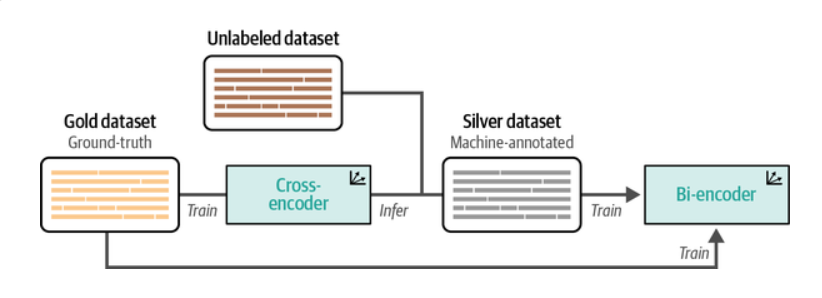

在我们进入前面的步骤之前，让我们先准备数据。我们不再使用原始的50,000个文档，而是使用10,000个文档的子集来模拟我们只有有限注释数据的设置。正如我们在余弦相似度损失的例子中所做的那样，给蕴涵一个1分，而中性和矛盾得到0分。

**Step 1:** Fine-tune a cross-encoder

In [ ]:
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset, Dataset
from sentence_transformers import InputExample
from sentence_transformers.datasets import NoDuplicatesDataLoader

# Prepare a small set of 10000 documents for the cross-encoder
dataset = load_dataset("glue", "mnli", split="train").select(range(10_000))
mapping = {2: 0, 1: 0, 0:1}

# Data Loader
gold_examples = [
    InputExample(texts=[row["premise"], row["hypothesis"]], label=mapping[row["label"]])
    for row in tqdm(dataset)
]
gold_dataloader = NoDuplicatesDataLoader(gold_examples, batch_size=32)

# Pandas DataFrame for easier data handling
gold = pd.DataFrame(
    {
    'sentence1': dataset['premise'],
    'sentence2': dataset['hypothesis'],
    'label': [mapping[label] for label in dataset['label']]
    }
)

100%|██████████| 10000/10000 [00:00<00:00, 25870.92it/s]


In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder

# Train a cross-encoder on the gold dataset
cross_encoder = CrossEncoder('bert-base-uncased', num_labels=2)
cross_encoder.fit(
    train_dataloader=gold_dataloader,
    epochs=1,
    show_progress_bar=True,
    warmup_steps=100,
    use_amp=False
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/312 [00:00<?, ?it/s]

**Step 2:** Create new sentence pairs

In [ ]:
# Prepare the silver dataset by predicting labels with the cross-encoder
silver = load_dataset("glue", "mnli", split="train").select(range(10_000, 50_000))
pairs = list(zip(silver['premise'], silver['hypothesis']))

**Step 3:** Label new sentence pairs with the fine-tuned cross-encoder (silver dataset)

In [ ]:
import numpy as np

# Label the sentence pairs using our fine-tuned cross-encoder
output = cross_encoder.predict(pairs, apply_softmax=True, show_progress_bar=True)
silver = pd.DataFrame(
    {
        "sentence1": silver["premise"],
        "sentence2": silver["hypothesis"],
        "label": np.argmax(output, axis=1)
    }
)

**Step 4:** Train a bi-encoder (SBERT) on the extended dataset (gold + silver dataset)

In [ ]:
# Combine gold + silver
data = pd.concat([gold, silver], ignore_index=True, axis=0)
data = data.drop_duplicates(subset=['sentence1', 'sentence2'], keep="first")
train_dataset = Dataset.from_pandas(data, preserve_index=False)

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Create an embedding similarity evaluator for stsb
val_sts = load_dataset('glue', 'stsb', split='validation')
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score/5 for score in val_sts["label"]],
    main_similarity="cosine"
)

In [ ]:
from sentence_transformers import losses, SentenceTransformer
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

# Define model
embedding_model = SentenceTransformer('bert-base-uncased')

# Loss function
train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Define the training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="augmented_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
)

# Train model
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator
)
trainer.train()

In [ ]:
# Evaluate our trained model
evaluator(embedding_model)

In [ ]:
trainer.accelerator.clear()

**Step 5**: Evaluate without silver dataset

In [ ]:
# Combine gold + silver
data = pd.concat([gold], ignore_index=True, axis=0)
data = data.drop_duplicates(subset=['sentence1', 'sentence2'], keep="first")
train_dataset = Dataset.from_pandas(data, preserve_index=False)

# Define model
embedding_model = SentenceTransformer('bert-base-uncased')

# Loss function
train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Define the training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="gold_only_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
)

# Train model
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator
)
trainer.train()

In [ ]:
# Evaluate our trained model
evaluator(embedding_model)

这种方法允许我们增加已经可用的数据集的大小，而不需要手动标记数十万个句子对。你可以通过只在黄金数据集上训练你的嵌入模型来测试你的白银数据的质量。性能上的差异表明你的白银数据集可能会给模型的质量增加多少。

⚠️ **VRAM Clean-up**
* `Restart` the notebook in order to clean-up memory if you move on to the next training example.

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

## **Unsupervised Learning**

要创建嵌入模型，我们通常需要标记数据。然而，并不是所有现实世界的数据集都有一组我们可以使用的漂亮的标签。相反，我们寻找在没有任何预定标签的情况下训练模型的技术——无监督学习。目前存在许多方法，如句子嵌入的简单对比学习(SimCSE)，对比张力(CT)，基于变压器的顺序去噪自动编码器(TSDAE)，和生成伪标记(GPL)。

在本节中，我们将重点关注TSDAE，因为它在无监督任务和领域自适应方面表现出色。

### Tranformer-based Denoising AutoEncoder (TSDAE)

TSDAE是一种非常优雅的方法，用于创建无监督学习的嵌入模型。该方法假设我们根本没有标记数据，也不需要我们人为地创建标签。

TSDAE的基本思想是，我们通过从输入句子中删除一定百分比的单词来给输入句子添加噪声。这个“受损”的句子被放入一个编码器，在它的上面有一个池化层，将其映射到一个句子嵌入。从这个句子嵌入中，解码器尝试从“受损”的句子中重建原始句子，但没有人工噪声。这里的主要概念是，句子嵌入越准确，重构出的句子就越准确。

这种方法与掩码语言建模非常相似，我们尝试重构和学习某些掩蔽词。在这里，我们不是重构蒙面词，而是尝试重构整个句子。

在训练之后，我们可以使用编码器从文本中生成嵌入，因为解码器只用于判断嵌入是否可以准确地重构原始句子。

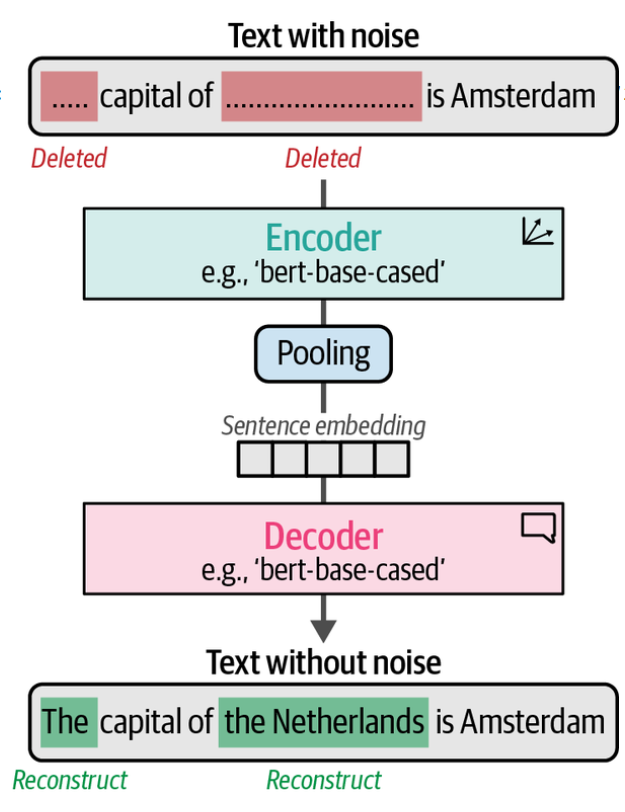

# Download additional tokenizer
import nltk
nltk.download('punkt')

In [ ]:
from tqdm import tqdm
from datasets import Dataset, load_dataset
from sentence_transformers.datasets import DenoisingAutoEncoderDataset

# Create a flat list of sentences
mnli = load_dataset("glue", "mnli", split="train").select(range(25_000))
flat_sentences = mnli["premise"] + mnli["hypothesis"]

# Add noise to our input data
damaged_data = DenoisingAutoEncoderDataset(list(set(flat_sentences)))

# Create dataset
train_dataset = {"damaged_sentence": [], "original_sentence": []}
for data in tqdm(damaged_data):
    train_dataset["damaged_sentence"].append(data.texts[0])
    train_dataset["original_sentence"].append(data.texts[1])
train_dataset = Dataset.from_dict(train_dataset)

In [ ]:
train_dataset[0]

In [ ]:
# # Choose a different deletion ratio
# flat_sentences = list(set(flat_sentences))
# damaged_data = DenoisingAutoEncoderDataset(
#     flat_sentences,
#     noise_fn=lambda s: DenoisingAutoEncoderDataset.delete(s, del_ratio=0.6)
# )

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Create an embedding similarity evaluator for stsb
val_sts = load_dataset('glue', 'stsb', split='validation')
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score/5 for score in val_sts["label"]],
    main_similarity="cosine"
)

接下来，我们像之前一样运行训练，但是使用 (CLS) 代币作为池化策略，而不是代币嵌入的平均池化。在TSDAE的论文中，这被证明是更有效的，因为平均池化会丢失位置信息，而使用 (CLS) 令牌。

In [ ]:
from sentence_transformers import models, SentenceTransformer

# Create your embedding model
word_embedding_model = models.Transformer('bert-base-uncased')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

使用我们的句子对，我们将需要一个损失函数，它尝试使用噪声句子来重建原始句子，即 DenoisingAutoEncoderLoss。通过这样做，它将学习如何准确地表示数据。它类似于掩码，但不知道实际的掩码在哪里。

此外，我们将两个模型的参数捆绑在一起。编码器的嵌入层和解码器的输出层没有单独的权值，而是共享相同的权值。这意味着一层中权重的任何更新也会反映在另一层中。

In [ ]:
from sentence_transformers import losses

# Use the denoising auto-encoder loss
train_loss = losses.DenoisingAutoEncoderLoss(
    embedding_model, tie_encoder_decoder=True
)
train_loss.decoder = train_loss.decoder.to("cuda")

In [ ]:
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

# Define the training arguments
args = SentenceTransformerTrainingArguments(
    output_dir="tsdae_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
)

# Train model
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator
)
trainer.train()

In [ ]:
# Evaluate our trained model
evaluator(embedding_model)

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

## 利用TSDAE进行领域自适应

当你有很少或没有标记数据可用时，你通常使用无监督学习来创建你的文本嵌入模型。然而，无监督技术的表现通常优于有监督技术，并且难以学习特定领域的概念。

这就是领域适应的用武之地。它的目标是将现有的嵌入模型更新到特定的文本域，该文本域包含来自源域的不同主题。图展示了域在内容上的不同。目标域或外域通常包含在源域或内域中没有找到的单词和主题。

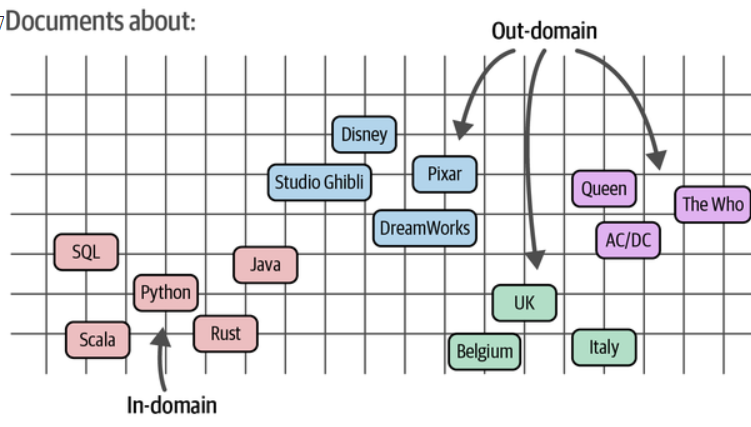

领域适应的一种方法被称为自适应预训练。首先使用无监督技术预训练特定于领域的语料库，例如前面讨论的TSDAE或屏蔽语言建模。然后，如图所示，你使用一个训练数据集来微调模型，这个数据集可以在你的目标领域之外，也可以在你的目标领域内。虽然来自目标领域的数据是首选，但域外数据也可以工作，因为我们从目标领域的无监督训练开始。

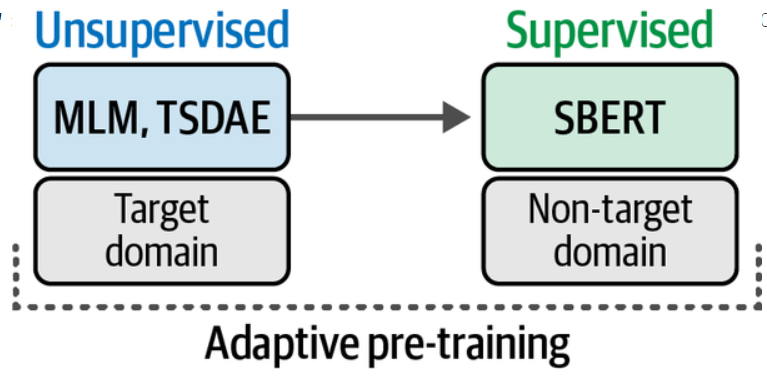

# Summary

在本章中，我们通过各种任务来创建和微调嵌入模型。我们讨论了嵌入的概念以及它们在以数字格式表示文本数据中的作用。然后，我们探索了许多嵌入模型的基本技术，即对比学习，它主要从(不)相似的文档对中学习。

使用流行的嵌入框架， sentence-transformers，然后我们使用预训练的BERT模型创建嵌入模型，同时探索不同的损失函数，如余弦相似度损失和MNR损失。我们讨论了文档的(非)相似对或三元组的集合如何对最终模型的性能至关重要。

在接下来的章节中，我们探讨了微调嵌入模型的技术。讨论了有监督和无监督的技术，例如用于领域自适应的Augmented SBERT和TSDAE。与创建嵌入模型相比，微调通常需要更少的数据，并且是使现有嵌入模型适应您的领域的好方法。